In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Assignment 1 for Henrik Bonsaksen og Mahmoud Khazei #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# all imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import logsumexp
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import re
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('tweets.csv', sep=',')

In [3]:
# change the sentiment text into values
data["airline_sentiment"]=data.airline_sentiment.map({"neutral":"0","positive":"1","negative":"-1"})

In [4]:
import string
string.punctuation
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)

In [5]:
user = '@[A-Za-z0-9]+'
url = 'https?://[^ ]+'
link = 'www.[^ ]+'
combined_p = '|'.join((user, url, link))
neg_dic = {"weren't":"were not", "isn't":"is not", "aren't":"are not", "wasn't":"was not", 
                "haven't":"have not","hasn't":"has not","hadn't":"had not", "won't":"will not",
                "wouldn't":"would not", "shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not", "can't":"can not", "couldn't":"could not",
               "don't":"do not", "doesn't":"does not", "didn't":"did not"}
neg = re.compile('\b(' + '|'.join(neg_dic.keys()) + ')\b')
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    stripped = re.sub(combined_p, '', text)
    lower_case = stripped.lower()
    neg_handled = neg.sub(lambda x: neg_dic[x.group()], lower_case)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tok.tokenize(letters) if len(x) > 1]
    drop_stopwords = [x for x in words if x not in stopwords.words('english')]
    return (" ".join(drop_stopwords)).strip()

In [6]:
X=data.iloc[:,10]
Y=data.iloc[:,1]

In [7]:
sentiment = data['airline_sentiment'].value_counts()
# adding labels
labels=['Negative','Neutral','Positive']
index = np.arange(len(labels))

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# making a bag of words 
vectorizer=CountVectorizer()
bag_of_words=vectorizer.fit_transform(X)
vc=vectorizer.get_feature_names
# print(bag_of_words.toarray())
# print(vectorizer.vocabulary_)

In [9]:
clean_tweets = []
for tweet in data.text:
    clean_tweets.append(tweet_cleaner(tweet))
X = pd.DataFrame(clean_tweets) #X var data['text']

In [10]:
X_train,X_test,Y_train,Y_test=train_test_split(bag_of_words,Y,test_size=0.2)

In [11]:
from sklearn.preprocessing import LabelBinarizer
# attempt to create naive bayes as a class
# followed steps from 
# https://ethen8181.github.io/machine-learning/text_classification/naive_bayes/naive_bayes.html

class NaiveBayes:
    def __init__(self, laplacesmooth = 1.0):
        self.laplacesmooth = laplacesmooth

    def fit(self, X, Y):
        # labeling
        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(Y).astype(np.float64)
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis = 1)

        self.classes_ = labelbin.classes_

        # sparse matrix, matrix multiplication
        self.feature_count_ = Y.T * X
        self.class_count_ = Y.sum(axis = 0)

        # compute feature log probability:
        # number of a particular word in a particular class / total number of words in that class
        smoothed_count = self.feature_count_ + self.laplacesmooth
        smoothed_class = np.sum(smoothed_count, axis = 1)
        self.feature_log_prob_ = (np.log(smoothed_count) -
                                  np.log(smoothed_class.reshape(-1, 1)))

        # compute class log prior:
        # number of observation in a particular class / total number of observation
        self.class_log_prior_ = (np.log(self.class_count_) -
                                 np.log(self.class_count_.sum()))
        return self
    
    def predict(self, X):
        joint_prob = self._joint_likelihood(X)
        pred_class = self.classes_[np.argmax(joint_prob, axis = 1)]
        return pred_class

    def predict_proba(self, X):
        joint_prob = self._joint_likelihood(X)

        joint_prob_norm = logsumexp(joint_prob, axis = 1, keepdims = True)
        pred_proba = np.exp(joint_prob - joint_prob_norm)
        return pred_proba

    def _joint_likelihood(self, X):
        joint_prob = X * self.feature_log_prob_.T + self.class_log_prior_
        return joint_prob

In [12]:
# initialization and fitting
model = NaiveBayes()
model.fit(X_train,Y_train)
predict=model.predict(X_test)

In [13]:
# calculate the accuracy of our classifier
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
# here we can see our accuracy is fairly good. Not the worst, not the best.
print("Naive Bayes classification accuracy: ", accuracy(Y_test, predict))

Naive Bayes classification accuracy:  0.7585382513661202


In [14]:
# function to take any sentence and predict its sentiment
def user_defined_sentences(sentence):
    st=[sentence]
    vect=vectorizer.transform(st)
    #print(vect.toarray())
    predict=model.predict(vect)
    positive =  ['1']
    negative = ['-1']
    neutral = ['0']
    print("The prediction for the sentiment is:")
    if predict == positive:
        print("\tPositive")
    elif predict == negative:
        print("\tNegative")
    else:
        print("\tNeutral")
    polarity=model.predict_proba(vect)
    print("Explanation for prediction: ", "\n\tNegative:", polarity[0][0], "\n\tPositive:", polarity[0][1], "\n\tNeutral:", polarity[0][2])
    
    plt.bar(index,polarity[0], color=(0.2, 0.5, 0.5, 1))
    plt.ylabel('Probability',fontsize=10)
    plt.xlabel('Prediction',fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=40)
    plt.title('Sentiment of Sentence', fontsize=15)
    plt.show()


Naive Bayes classification accuracy:  0.7585382513661202
Skriv inn en tweet eller exit for å lukke:
test bajs cool
The prediction for the sentiment is:
	Neutral
Explanation for prediction:  
	Negative: 0.11284993330210574 
	Positive: 0.5413125482275835 
	Neutral: 0.34583751847030947


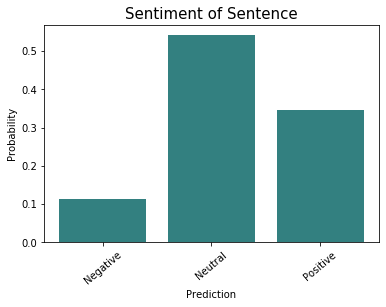

Skriv inn en tweet eller exit for å lukke:
great nice cool
The prediction for the sentiment is:
	Positive
Explanation for prediction:  
	Negative: 0.036056451369578274 
	Positive: 0.006472851767763189 
	Neutral: 0.9574706968626586


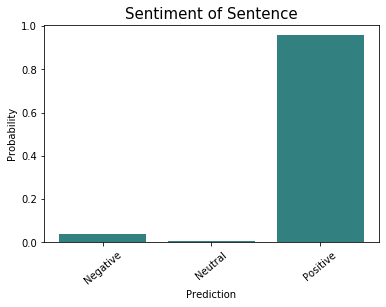

In [ ]:
def main():
    
    # here we can see our accuracy is fairly good. Not the worst, not the best.
    print("Naive Bayes classification accuracy: ", accuracy(Y_test, predict))
    while True:
        # command line utility for typing in any text or tweet
        user_input = input("Skriv inn en tweet eller exit for å lukke:\n")

        if user_input != 'exit':
            user_defined_sentences(user_input)
        elif user_input == 'exit':
            sys.exit(0)

if __name__ == "__main__":
    main()

In [ ]:
################################ CORRECT PREDICTIONS: #####################################
#
# tweet[14637]: "@AmericanAir guarantee no retribution? If so, I'd be glad to share."
# prediction: neutral
# correct sentiment: neutral
# The numbers for the prediction:  
#    negative: 0.40881885 
#    neutral: 0.57140138
#    positive: 0.01977977
#
# tweet[17] "@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!"
# prediction: negative
# correct sentiment: negative
# The numbers for the prediction:  
#    negative: 9.99535358e-01
#    neutral: 4.58533670e-04 
#    positive: 6.10875730e-06


################################ WRONG PREDICTIONS: #####################################
# 
# tweet[2]: "@VirginAmerica I didn't today... Must mean I need to take another trip!"
# prediction: negative
# correct sentiment: neutral
# The numbers for the prediction:  
#    negative: 0.89608717 
#    neutral: 0.09819443 
#    positive: 0.0057184
# 
# tweet[6] "@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
# prediction: negative
# correct sentiment: positive
# The numbers for the prediction:  
#     negative: 0.68502534 
#     neutral: 0.15810652
#     positive: 0.15686814


##################################### COMMENTS: ######################################
# When it comes to the wrong ones, we assumed the neutral ones would be hardest
# to predict, and it would more often predict these close-to-correct, but end up wrong.
# 
# numbers will also change for each time the script is reset, as the actual data in 
# the training and test sets will change.